In [1]:
import lfx
import flax.nnx as nnx
import flax
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt
import flax.typing as ftp
import typing as tp

# Free theory

In [2]:
mass = 0.5
lat_shape = (32, 32)

ks = lfx.fft_momenta(lat_shape, lattice=True)
spectrum = 1 / (mass**2 + jnp.sum(ks**2, axis=-1))

# note: specturm here could also be a nnx.Param to make it trainable;
# or set it to output of (trainable) function of ks
scaling = lfx.SpectrumScaling(spectrum)

free_theory_prior = lfx.Sampler(
    lfx.IndependentNormal(lat_shape, rngs=nnx.Rngs(sample=0)),
    scaling
)

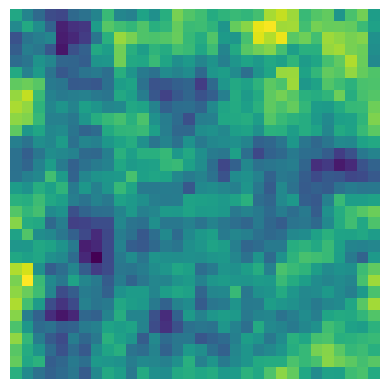

In [3]:
x, _ = free_theory_prior.sample()
plt.imshow(x)
plt.axis('off')
plt.show()

# Phi4

In [4]:
# "build" provides a constructor similar to the jaxnf version

rngs = nnx.Rngs(params=0)
vf = lfx.Phi4CNF.build((32, 32), (), rngs=rngs)

## Transfer model parameters from previous version

In [5]:
# convolution conventions change between frameworks, need to relabel orbits
import jaxnf

def reshuffle_orbits(kernel_params, kernel_shape):
    oc, old_orbits = jaxnf.lattice.conv_utils.kernel_d4(kernel_shape)
    kernel = jaxnf.lattice.conv_utils.unfold_kernel(kernel_params, old_orbits)
    for d, s in enumerate(kernel.shape[:-2]):
        kernel = jnp.roll(kernel, -1 + (s % 2), axis=d)
    return lfx.conv.fold_kernel(kernel, vf.conv.orbits, oc)

In [6]:
# transfer jaxnf -> this

# setup and get jaxnf parameters for demonstration
jaxnf_vf = jaxnf.lattice.Phi4CNF((32, 32))
params_jxnf = jaxnf_vf.init(
    rngs.params(), 0.1, (jnp.zeros((32, 32, 1)), 0.0))['params']

params_jxnf = jax.tree.map(lambda p: p + np.random.normal(size=p.shape), params_jxnf)

# transfer parameters
_, params = nnx.split(vf)

params.replace_by_pure_dict({
    'conv': {'kernel_params': reshuffle_orbits(params_jxnf['kernel'], (32, 32))},
    'feature_map': {'features': {0: params_jxnf['features_0']}},
    'feature_superposition': params_jxnf['freq_superpos'],
    'time_kernel': {'superposition': params_jxnf['time_superpos']}
})

# in place update
nnx.update(vf, params)

In [7]:
# transfer haiku -> this
params_haiku = np.load('../jax-flows/share-pullback/all-parameters/single-L32.npz', allow_pickle=True)['params'].item()

_, params = nnx.split(vf)

params.replace_by_pure_dict({
    'conv': {'kernel_params': reshuffle_orbits(params_haiku['~']['w'], (32, 32))},
    'feature_map': {'features': {0: {'phi_freq': params_haiku['~']['phi_freq'][None]}}},
    'feature_superposition': params_haiku['~']['freq_superpos'],
    'time_kernel': {'superposition': params_haiku['~']['time_superpos']}
})

# in place update
nnx.update(vf, params)

## Sampling

In [8]:
flow = lfx.ContFlowRK4(vf, dt=1/50)
sampler = lfx.Sampler(
    lfx.IndependentNormal((32, 32), rngs=nnx.Rngs(sample=0)),
    flow,
)

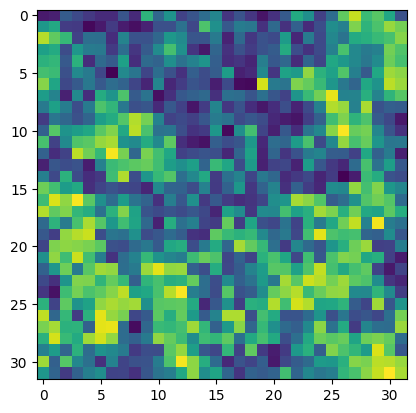

In [10]:
x, _ = sampler.sample(())
plt.imshow(x)
plt.show()